<h2> Introduction </h2>
In this kernel we will use Logistic Regression and Deep Learning methodologies to detect whether a text comment is a normal comment or a toxic (there are 6 toxic categories here). 



<h2> Goals: </h2>
<ul>
<li> Convert text comment to vectors using TFIDF, then build logistic regression to predict 6 toxic labels seperately</li>
<li> Convert text comment to tokens using Tokenizer, then build deep learning model to predict 6 toxic labels all together (multi label classification) </li>
<li> Convert text comment to tokens using Tokenizer, build deep learning model with GloVe weights, then predict 6 toxic labels all together (multi label classification) </li>
<li> Ensemble all 3 models to get a better prediction</li>


<h2> Outline: </h2>
    
    
I. <b>Data Overview </b><br>
a) [Load Data](#load)<br>
b) [Data Overview](#overview)<br><br>
    
II. <b>TFIDF + Logistic Regression </b><br>
a) [TFIDF](#TFIDF)<br>
b) [MaxAbsScaler](#scaler)<br>
c) [Logistic Regression](#lr)<br>

III. <b>Tokenizer + Deep learning </b><br>
a) [Tokenizer](#token)<br>
b) [Padding](#padding)<br>
c) [Build Deep learning model](#dlmodel)<br>


IV. <b>Tokenizer + Deep learning + GloVe</b><br>
a) [Load Embedding from GloVe](#embedding)<br>
b) [Build deep learning model](#dlmodel2)<br>

    
V. <b>Ensemble and model comparison</b><br>
a) [Ensemble 3 models](#ensemble)<br>
b) [Model performance comparison](#performance)<br>
c) [Error analysis](#error)<br>

# Prepare the data

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from scipy.sparse import hstack
from sklearn.pipeline import make_union
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer, MaxAbsScaler
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report, confusion_matrix

In [25]:
import keras
import tensorflow as tf
import sys, os, re, csv, codecs, numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model,Sequential
from keras import initializers, regularizers, constraints, optimizers, layers

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Loading the train and test files
<a id="load"></a>

In [3]:

train = pd.read_csv('../input/jigsaw-toxic-comment-classification-challenge/train.csv.zip')
test = pd.read_csv('../input/jigsaw-toxic-comment-classification-challenge/test.csv.zip')
test_label = pd.read_csv('../input/jigsaw-toxic-comment-classification-challenge/test_labels.csv.zip')
print(train.head())
print(test.head())
print(test_label.head())

                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  
0             0        0       0       0              0  
1             0        0       0       0              0  
2             0        0       0       0              0  
3             0        0       0       0              0  
4             0        0       0       0              0  
                 id                                       comment_text
0  00001cee341fdb12  Yo bitch Ja Rule is more succesful then you'll...
1  0000247867823ef7  ==

In [5]:
print('-'*20+'Train data label distribution'+'-'*20 +'\n')
print(train.drop(['id','comment_text'],axis=1).apply(pd.Series.value_counts,normalize=True))
print("\n")

print('-'*20+'Join test data and label then remove the -1s'+'-'*20 +'\n')
test_wlabel = pd.merge(test, test_label, how='left',on='id')

test_wlabel = test_wlabel[test_wlabel['toxic']!= -1]
print(test_wlabel.drop(['id','comment_text'],axis=1).apply(pd.Series.value_counts,normalize=True))
print("\n")
print("test data count")
print(test_wlabel.count())

--------------------Train data label distribution--------------------

      toxic  severe_toxic   obscene    threat    insult  identity_hate
0  0.904156      0.990004  0.947052  0.997004  0.950636       0.991195
1  0.095844      0.009996  0.052948  0.002996  0.049364       0.008805


--------------------Join test data and label then remove the -1s--------------------

      toxic  severe_toxic   obscene    threat    insult  identity_hate
0  0.904811      0.994264  0.942308  0.996702  0.946435       0.988871
1  0.095189      0.005736  0.057692  0.003298  0.053565       0.011129


test data count
id               63978
comment_text     63978
toxic            63978
severe_toxic     63978
obscene          63978
threat           63978
insult           63978
identity_hate    63978
dtype: int64


## Data Overview
<a id="Overview"></a>

check if there is any nulls in the data

In [7]:
train.isnull().any(),test.isnull().any() #No nulls

(id               False
 comment_text     False
 toxic            False
 severe_toxic     False
 obscene          False
 threat           False
 insult           False
 identity_hate    False
 dtype: bool, id              False
 comment_text    False
 dtype: bool)

Prepare the data for modeling

In [8]:
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y_train = train[list_classes]
y_test = test_wlabel[list_classes]
list_sentences_train = train["comment_text"]
list_sentences_test = test_wlabel["comment_text"]

# TFIDF + Logistic

## TFIDF at word level and char level
<a id="TFIDF"></a>

In [9]:
# all_text = pd.concat([list_sentences_train, list_sentences_test]) # Fit only on Training data

In [9]:
word_vectorizer = TfidfVectorizer(max_features=30000, 
                                  stop_words='english',
                                  strip_accents = 'ascii', 
                                  token_pattern=r'[a-zA-Z]{1,}',
                                  ngram_range=(1, 4))

word_vectorizer.fit(list_sentences_train)
train_word_features = word_vectorizer.transform(list_sentences_train)
test_word_features = word_vectorizer.transform(list_sentences_test)

In [10]:
char_vectorizer = TfidfVectorizer(analyzer='char', 
                                  max_features=30000, 
                                  strip_accents='ascii',
                                  ngram_range=(1, 4))

char_vectorizer.fit(list_sentences_train)
train_char_features = char_vectorizer.transform(list_sentences_train)
test_char_features = char_vectorizer.transform(list_sentences_test)

In [11]:
train_features = hstack([train_char_features,train_word_features])
test_features = hstack([test_char_features,test_word_features])

## MaxAbsScaler 
<a id='scaler'> </a>

In [12]:
scaler = MaxAbsScaler()
scaler.fit(train_features)
train_features_scaled = scaler.transform(train_features)
test_features_scaled = scaler.transform(test_features)

<h2>Logistic Regression</h2>
<a id='lr'></a>
<li>Use warm start to speed up convergence , and utilize the learning from the previous model.</li>
<li>Use C = 0.01 to specify stronger regularization, and speed up convergence. </li>
<li>Use solver = 'sag' to speed up convergence.</li>
<li>Use class_weight to reduce the imbalance issue.</li>

In [13]:
%%time
class_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
score = []
y_pred_lr = pd.DataFrame()
for class_name in class_names:
    train_target = y_train[class_name]
    test_target = y_test[class_name]
    weight = sum(train_target==0)*0.2/sum(train_target==1)
    lr = LogisticRegression(solver = 'sag', C=0.01, class_weight={0:0.2,1: weight},max_iter=1000, warm_start=True)
    lr.fit(train_features_scaled, train_target)
    y_pred = lr.predict(train_features_scaled)
    auc_score = roc_auc_score(train_target,y_pred)
    print('Train score for class {} is {}'.format(class_name, auc_score))
    y_proba = lr.predict_proba(test_features_scaled)[:,1]
    y_pred_lr[class_name] = y_proba
    auc_score = roc_auc_score(test_target,y_proba>=0.5)
    score.append(auc_score)
    print('Test score for class {} is {}'.format(class_name, auc_score))

    feature_importance = pd.DataFrame({'coef':lr.coef_[0],'feature_name':char_vectorizer.get_feature_names()+word_vectorizer.get_feature_names()})
    # feature_importance
    feature_importance.sort_values('coef',ascending=False, inplace=True)
    print("top 10 variables are : {}".format(feature_importance['feature_name'].head(10).tolist()))
print("\nscore for total class is {}".format(np.mean(score)))

Train score for class toxic is 0.8934876290700772
Test score for class toxic is 0.8546278510975499
top 10 variables are : ['uck', 'ck', 'uc', 'fuc', 'fuck', ' fuc', '!', 'fuck', 'u', 'hit']
Train score for class severe_toxic is 0.9749231897928863
Test score for class severe_toxic is 0.9254235028755543
top 10 variables are : ['uck', 'ck', 'uc', 'fuck', 'fuc', 'fuck', ' fuc', 'ck ', 'fu', 'u']
Train score for class obscene is 0.9299836117230655
Test score for class obscene is 0.8869842342721195
top 10 variables are : ['uck', 'uc', 'fuc', 'ck', 'fuck', ' fuc', 'fuck', 'shit', 'ass', 'fu']


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Train score for class threat is 0.9708589042166252
Test score for class threat is 0.9247138408291382
top 10 variables are : ['die', 'die', ' die', 'kill', 'ie', 'kill', ' kil', 'kil', '!', '!!!']
Train score for class insult is 0.9250751534254967
Test score for class insult is 0.882027633529047
top 10 variables are : ['uck', 'ck', 'uc', 'fuc', 'fuck', ' fuc', 'u', 'idi', 'dio', 'idio']
Train score for class identity_hate is 0.9649651748829319
Test score for class identity_hate is 0.9225776523378906
top 10 variables are : ['gay', 'gay', ' gay', 'g', 'igg', 'nigg', 'ga', ' ga', 'gg', 'nig']

score for total class is 0.8993924524902166
CPU times: user 45min 50s, sys: 6.59 s, total: 45min 56s
Wall time: 45min 57s


# Tokenizer + LSTM

## Tokenizer
<a id='token'> <a>

In [26]:
max_features = 20000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)

In [24]:
#commented it due to long output
#for occurence of words
#tokenizer.word_counts
#for index of words
#tokenizer.word_index

<h2>Padding</h2>
<a id='paddnig'> </a>
    
make sure they all have same input length

In [27]:
maxlen = 200
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)

In [28]:
totalNumWords = [len(one_comment) for one_comment in list_tokenized_train]

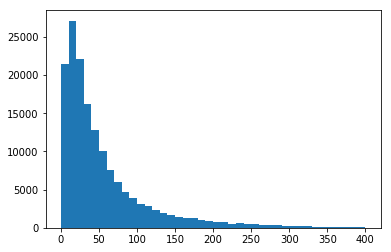

In [29]:
plt.hist(totalNumWords,bins = np.arange(0,410,10))#[0,50,100,150,200,250,300,350,400])#,450,500,550,600,650,700,750,800,850,900])
plt.show()

## Build the deep learning model
<a id='dlmodel'> <a>

In [30]:
inp = Input(shape=(maxlen, )) 
embed_size = 100
x = Embedding(max_features, embed_size)(inp)
x = LSTM(50, return_sequences=True,name='lstm_layer')(x)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(6, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

In [31]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 200, 100)          2000000   
_________________________________________________________________
lstm_layer (LSTM)            (None, 200, 50)           30200     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 50)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                2550      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
__________

In [40]:
batch_size = 32
epochs = 2
early_stopping_cb = keras.callbacks.EarlyStopping(patience=2) # Leave it here for future use, but in this case 2 epochs are good
model.fit(X_t,y_train, batch_size=batch_size, epochs=2, validation_split=0.1,callbacks=[early_stopping_cb])

Train on 143613 samples, validate on 15958 samples
Epoch 1/2
143613/143613 [==============================] - 1047s 7ms/step - loss: 0.0700 - acc: 0.9776 - val_loss: 0.0499 - val_acc: 0.9816
Epoch 2/2
143613/143613 [==============================] - 1062s 7ms/step - loss: 0.0455 - acc: 0.9829 - val_loss: 0.0471 - val_acc: 0.9823


View the output of embedding layer

In [64]:
# from keras import backend as K

# # with a Sequential model
# get_3rd_layer_output = K.function([model.layers[0].input],
#                                   [model.layers[1].output])
# layer_output = get_3rd_layer_output([X_t[:1]])[0]
# layer_output.shape
# # layer_output

(1, 200, 128)

In [41]:
y_pred = model.predict(X_te)
print("AUCROC score of the model", roc_auc_score(y_test,y_pred))

AUCROC score of the model 0.9716946063649258


Plot the AUCROC curve to get the appropriate decision threshold (0.03 is chosen in this job)

# Tokenizer + LSTM + Pretrained model GloVe (100d)

## Load GloVe embedding file
<a id='embedding'> <a>

In [32]:
EMBEDDING_FILE='../input/glove-global-vectors-for-word-representation/glove.6B.100d.txt'

In [33]:
def get_coefs(word,*arr): 
    return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.strip().split()) for o in open(EMBEDDING_FILE))

Use these vectors to create our embedding matrix, with random initialization for words that aren't in GloVe. We'll use the same mean and stdev of embeddings the GloVe has when generating the random init.

In [34]:
all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
# emb_mean,emb_std

In [35]:
## Use the same parameters as before
# embed_size = 100 # how big is each word vector
# max_features = 20000 # how many unique words to use (i.e num rows in embedding vector)
# maxlen = 200 # max number of words in a comment to use

In [36]:
word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

## Build the deep learning model with embedding weights initialization
<a id='dlmodel2'> <a>

In [37]:
inp2 = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp2)
x = LSTM(50, return_sequences=True)(x)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(6, activation="sigmoid")(x)
model2 = Model(inputs=inp2, outputs=x)
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [38]:
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 200)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 200, 100)          2000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 200, 50)           30200     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 50)                0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 50)                2550      
_________________________________________________________________
dropout_4 (Dropout)          (None, 50)                0         
__________

In [39]:
batch_size = 32
epochs = 2
early_stopping_cb = keras.callbacks.EarlyStopping(patience=2) # Leave it here for future use, but in this case 2 epochs are good
model2.fit(X_t,y_train, batch_size=batch_size, epochs=2, validation_split=0.1,callbacks=[early_stopping_cb])

Train on 143613 samples, validate on 15958 samples
Epoch 1/2
143613/143613 [==============================] - 1023s 7ms/step - loss: 0.0584 - acc: 0.9796 - val_loss: 0.0477 - val_acc: 0.9819
Epoch 2/2
143613/143613 [==============================] - 1013s 7ms/step - loss: 0.0434 - acc: 0.9833 - val_loss: 0.0460 - val_acc: 0.9828


In [42]:
y_pred2 = model2.predict(X_te)
print("AUCROC score of the model", roc_auc_score(y_test,y_pred2))

AUCROC score of the model 0.977074902340322


# Ensemble and model comparison

## Ensemble 3 models
<a id='ensemble'></a>

In [64]:
y_pred = pd.DataFrame(y_pred,columns=class_names)
y_pred2 = pd.DataFrame(y_pred2,columns=class_names)

In [71]:
y_test.head()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
5,0,0,0,0,0,0
7,0,0,0,0,0,0
11,0,0,0,0,0,0
13,0,0,0,0,0,0
14,0,0,0,0,0,0


In [74]:
ensemble_score = pd.DataFrame()

for class_name in class_names:
    ensemble_score[class_name] = (y_pred_lr[class_name] + y_pred[class_name] + y_pred2[class_name])/3
# #     ensemble_score[class_name] = (y_pred[class_name] + y_pred2[class_name])/2
#     fpr, tpr, thresholds = roc_curve(y_test[class_name],ensemble_score[class_name])
#     idx = np.argmax(tpr - fpr ) 
#     print('Confusion matrix for class {}'.format(class_name))
#     print(confusion_matrix(y_test[class_name],ensemble_score[class_name]>=thresholds[idx]))
#     print('classification report for class {}'.format(class_name))
#     print(classification_report(y_test[class_name],ensemble_score[class_name]>=thresholds[idx]))




## Model performance comparison
<a id='performance'></a>

In [76]:
print("AUCROC score of Logistic Regression", roc_auc_score(y_test,y_pred_lr))
print("AUCROC score of LSTM", roc_auc_score(y_test,y_pred))
print("AUCROC score of LSTM+GloVe", roc_auc_score(y_test,y_pred2))
print("\n")
print("AUCROC score of Ensemble", roc_auc_score(y_test,ensemble_score))

AUCROC score of Logistic Regression 0.9664527415305842
AUCROC score of LSTM 0.9716946063649258
AUCROC score of LSTM+GloVe 0.977074902340322


AUCROC score of Ensemble 0.9790053699645043


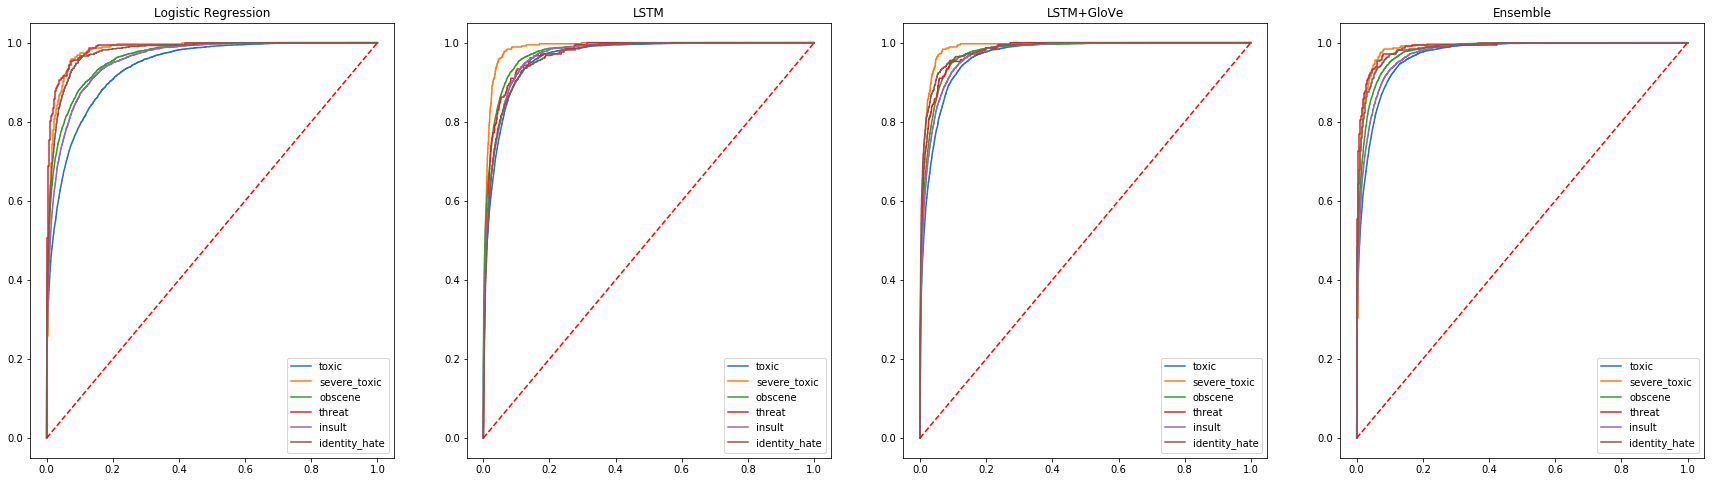

In [77]:
fig, ax = plt.subplots(1,4,figsize=(30,8))
for i in range(6):
    ax[0].set_title('Logistic Regression')
    fpr, tpr, thresholds = roc_curve(y_test.iloc[:,i],y_pred_lr.iloc[:,i])
    ax[0].plot(fpr, tpr, label=class_names[i])
    ax[0].legend(loc='best')
    
    ax[1].set_title('LSTM')
    fpr, tpr, thresholds = roc_curve(y_test.iloc[:,i],y_pred.iloc[:,i])
    ax[1].plot(fpr, tpr, label=class_names[i])
    ax[1].legend(loc='best')
    
    ax[2].set_title('LSTM+GloVe')
    fpr, tpr, thresholds = roc_curve(y_test.iloc[:,i],y_pred2.iloc[:,i])
    ax[2].plot(fpr, tpr, label=class_names[i])
    ax[2].legend(loc='best')
    
    ax[3].set_title('Ensemble')
    fpr, tpr, thresholds = roc_curve(y_test.iloc[:,i],ensemble_score.iloc[:,i])
    ax[3].plot(fpr, tpr, label=class_names[i])
    ax[3].legend(loc='best')

ax[0].plot([0, 1], [0, 1],'r--')    
ax[1].plot([0, 1], [0, 1],'r--')    
ax[2].plot([0, 1], [0, 1],'r--')
ax[3].plot([0, 1], [0, 1],'r--')

plt.show()

In [118]:
optimal_threshods_lr = []
optimal_threshods_dl1 = []
optimal_threshods_dl2 = []
optimal_threshods_es = []

print("-"*20+"Logistic Regression decision threshold:"+"-"*20)
for i in range(len(class_names)):
    fpr, tpr, thresholds = roc_curve(y_test.iloc[:,i],y_pred_lr.iloc[:,i])
    idx = np.argmax(tpr - fpr ) 
    print("optimal fpr, tpr: ",fpr[idx], ",",tpr[idx])
    print("optimal threshold: ",thresholds[idx])
    optimal_threshods_lr.append(thresholds[idx])

    
print("-"*20+"LSTM decision threshold:"+"-"*20)

for i in range(len(class_names)):
    fpr, tpr, thresholds = roc_curve(y_test.iloc[:,i],y_pred.iloc[:,i])
    idx = np.argmax(tpr - fpr ) 
    print("optimal fpr, tpr: ",fpr[idx], ",",tpr[idx])
    print("optimal threshold: ",thresholds[idx])
    optimal_threshods_dl1.append(thresholds[idx])

print("-"*20+"LSTM+GloVe decision threshold:"+"-"*20)
for i in range(len(class_names)):
    fpr, tpr, thresholds = roc_curve(y_test.iloc[:,i],y_pred2.iloc[:,i])
    idx = np.argmax(tpr - fpr ) 
    print("optimal fpr, tpr: ",fpr[idx], ",",tpr[idx])
    print("optimal threshold: ",thresholds[idx])
    optimal_threshods_dl2.append(thresholds[idx])
    
print("-"*20+"Ensemble decision threshold:"+"-"*20)
for i in range(len(class_names)):
    fpr, tpr, thresholds = roc_curve(y_test.iloc[:,i],ensemble_score.iloc[:,i])
    idx = np.argmax(tpr - fpr ) 
    print("optimal fpr, tpr: ",fpr[idx], ",",tpr[idx])
    print("optimal threshold: ",thresholds[idx])
    optimal_threshods_es.append(thresholds[idx])

--------------------Logistic Regression decision threshold:--------------------
optimal fpr, tpr:  0.1675822277501382 , 0.8809523809523809
optimal threshold:  0.4747987292783793
optimal fpr, tpr:  0.07446825234629231 , 0.9591280653950953
optimal threshold:  0.3801450339557767
optimal fpr, tpr:  0.11013983114104202 , 0.8935247900298022
optimal threshold:  0.4378975057770754
optimal fpr, tpr:  0.07925729609359072 , 0.957345971563981
optimal threshold:  0.2325093099911676
optimal fpr, tpr:  0.13950223778302587 , 0.9112926758097462
optimal threshold:  0.41017811589694436
optimal fpr, tpr:  0.09679764802579585 , 0.9564606741573034
optimal threshold:  0.41780532714492724
--------------------LSTM decision threshold:--------------------
optimal fpr, tpr:  0.13023424543946932 , 0.9403940886699508
optimal threshold:  0.22579838
optimal fpr, tpr:  0.06366823348163053 , 0.9782016348773842
optimal threshold:  0.01373294
optimal fpr, tpr:  0.1057773649377146 , 0.9520455161202926
optimal threshold:  

In [114]:
class_names=['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
y_pred_label1 = pd.DataFrame()
y_pred_label2 = pd.DataFrame()
y_pred_label3 = pd.DataFrame()
y_pred_label4 = pd.DataFrame()


for i in range(len(class_names)):
    print('classification report for class {}'.format(class_names[i]))
    
    print("-"*20+"Logistic Regression:"+"-"*20)
#     print('Confusion matrix for class {}'.format(class_names[i]))
#     print(confusion_matrix(y_test.iloc[:,i],y_pred[:,i]>=optimal_threshods_lr[i]))  
    y_pred_label1[class_names[i]] = y_pred_lr.iloc[:,i]>=optimal_threshods_lr[i]
    print(classification_report(y_test.iloc[:,i], y_pred_label1[class_names[i]]))
    
    
    print("-"*20+"LSTM:"+"-"*20)
    y_pred_label2[class_names[i]] = y_pred.iloc[:,i]>=optimal_threshods_dl1[i]
    print(classification_report(y_test.iloc[:,i], y_pred_label2[class_names[i]]))
    
    
    print("-"*20+"LSTM+GloVe:"+"-"*20)
    y_pred_label3[class_names[i]] = y_pred2.iloc[:,i]>=optimal_threshods_dl2[i]
    print(classification_report(y_test.iloc[:,i], y_pred_label3[class_names[i]]))
    
    print("-"*20+"ensemble_score:"+"-"*20)
    y_pred_label4[class_names[i]] = ensemble_score.iloc[:,i]>=optimal_threshods_es[i]
    print(classification_report(y_test.iloc[:,i],y_pred_label4[class_names[i]]))

classification report for class toxic
--------------------Logistic Regression:--------------------
             precision    recall  f1-score   support

          0       0.99      0.83      0.90     57888
          1       0.36      0.88      0.51      6090

avg / total       0.93      0.84      0.86     63978

--------------------LSTM:--------------------
             precision    recall  f1-score   support

          0       0.99      0.87      0.93     57888
          1       0.43      0.94      0.59      6090

avg / total       0.94      0.88      0.90     63978

--------------------LSTM+GloVe:--------------------
             precision    recall  f1-score   support

          0       0.99      0.88      0.93     57888
          1       0.44      0.94      0.60      6090

avg / total       0.94      0.88      0.90     63978

--------------------ensemble_score:--------------------
             precision    recall  f1-score   support

          0       0.99      0.87      0.93     5

From the above comparison, the ensemble method performs the best!

## Error Analysis
<a id='error'></a>

In [119]:
test_text_score = pd.concat([list_sentences_test.reset_index(drop=True),\
                             y_test.reset_index(drop=True),\
                             y_pred_lr.add_suffix('_pred1'),\
                             y_pred.add_suffix('_pred2'),\
                             y_pred2.add_suffix('_pred3'),
                             ensemble_score.add_suffix('_pred4'),
                             y_pred_label1.add_suffix('_label1').astype(int),
                             y_pred_label2.add_suffix('_label2').astype(int),
                             y_pred_label3.add_suffix('_label3').astype(int),
                             y_pred_label4.add_suffix('_label4').astype(int)
                            ] ,axis=1)
test_text_score.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,toxic_pred1,severe_toxic_pred1,obscene_pred1,...,obscene_label3,threat_label3,insult_label3,identity_hate_label3,toxic_label4,severe_toxic_label4,obscene_label4,threat_label4,insult_label4,identity_hate_label4
0,Thank you for understanding. I think very high...,0,0,0,0,0,0,0.098785,0.043803,0.073406,...,0,0,0,0,0,0,0,0,0,0
1,:Dear god this site is horrible.,0,0,0,0,0,0,0.673089,0.160330,0.323827,...,0,1,1,0,1,0,0,0,1,0
2,"""::: Somebody will invariably try to add Relig...",0,0,0,0,0,0,0.278937,0.034795,0.160991,...,0,0,0,0,0,0,0,0,0,0
3,""" \n\n It says it right there that it IS a typ...",0,0,0,0,0,0,0.149458,0.027432,0.133825,...,0,0,0,0,0,0,0,0,0,0
4,""" \n\n == Before adding a new product to the l...",0,0,0,0,0,0,0.058472,0.011803,0.058542,...,0,0,0,0,0,0,0,0,0,0


In [125]:
# Take a look at the labels that are wrongly predicted
label = 'toxic'

test_text_score[(test_text_score[label]==0) & (test_text_score[label+'_label4'] !=0)][['comment_text', label+'_label1',label+'_label2',label+'_label3']].head(10)

,comment_text,toxic_label1,toxic_label2,toxic_label3
1,:Dear god this site is horrible.,1,1,1
9,Please stop. If you continue to vandalize Wiki...,0,1,0
12,. \n\n Jews are not a race because y...,1,1,0
27,I WILL BURN YOU TO HELL IF YOU REVOKE MY TALK ...,1,1,1
56,"""This is just bizarre. Ani Medjool's abuse of ...",1,1,1
61,== black mamba == \n\n It.is ponious snake of ...,1,0,0
63,"**I just revamped WP:FART, I thought a little ...",0,1,1
78,""" \n\n == Shameless Canvass == \n\n Hello, Dia...",1,1,1
79,WHAT THE HELL \n\n Justin,1,1,1
87,"::::Buffoon Synonyms: bozo, buffo, clown, c...",1,1,1


In [135]:
# test_text_score.loc[12,'comment_text']